## Set global variables

In [1]:
course_metrics = {'course_name' : [],
                  'val_binary_accuracy' : [],
                  'test_accuracy' : [],
                  'test_f1_score' : [] }

In [2]:
import os

In [3]:
CONSOLIDATED_DATA_DIR = 'processed/'
COURSE_LIST = [d[0][10:] for d in os.walk(CONSOLIDATED_DATA_DIR)][1:]

In [4]:
COURSE_LIST

['HarvardXCB22x2013_Spring',
 'HarvardXCS50x2012',
 'HarvardXER22x2013_Spring',
 'HarvardXPH207x2012_Fall',
 'HarvardXPH278x2013_Spring',
 'MITx14.73x2013_Spring',
 'MITx2.01x2013_Spring',
 'MITx3.091x2012_Fall',
 'MITx3.091x2013_Spring',
 'MITx6.002x2012_Fall',
 'MITx6.002x2013_Spring',
 'MITx6.00x2012_Fall',
 'MITx6.00x2013_Spring',
 'MITx7.00x2013_Spring',
 'MITx8.02x2013_Spring',
 'MITx8.MReV2013_Summer']

In [5]:
DATA_DIR = 'processed-final/'

## Design the feed-forward neural net

In [6]:
import pandas as pd
import numpy as np
import tensorflow as tf

C:\Users\kimmcodxb\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [7]:
np.random.seed(20130810)
tf.set_random_seed(20130810)

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
%matplotlib inline
sns.set_style('ticks', {'grid_color' : '0.9'})
sns.set_context('talk', font_scale=1.2)
sns.set_palette('gray')

In [10]:
from keras.models import Sequential, load_model

from keras.layers import Dense, Activation, Dropout, BatchNormalization

from keras.losses import binary_crossentropy

from keras.optimizers import RMSprop, Adam

from keras.metrics import binary_accuracy

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from keras import backend as K

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

In [12]:
def build(network_type=Sequential, 
          nb_initial_layer=64,
          dense_layer_lst=[64],
          nb_final_layer=1,
          learning_rate=1e-4):
    
    model = network_type()
    
    model.add(Dense(nb_initial_layer, input_shape=(features_train.shape[1], )))
    model.add(Activation('relu'))
    
    model.add(BatchNormalization())
    
    for nb_units in dense_layer_lst:
        model.add(Dense(nb_units))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
    model.add(Dense(nb_final_layer))
    model.add(Activation('sigmoid'))
    
    model.compile(optimizer=Adam(lr=learning_rate),
                  loss=binary_crossentropy,
                  metrics=[binary_accuracy])
    
    return model

In [13]:
def plot_loss(fit_history, course_name):
    epochs = range(1, len(fit_history['binary_accuracy'])+1)
    
    plt.figure(figsize=(12, 6))
    
    plt.plot(epochs, fit_history['loss'], '--', label='Training loss')
    plt.plot(epochs, fit_history['val_loss'], '-', label='Validation loss')
    
    plt.title('Training and Validation loss for ' + course_name)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

In [14]:
def plot_accuracy(fit_history, course_name):
    epochs = range(1, len(fit_history['binary_accuracy'])+1)
    
    plt.figure(figsize=(12, 6))
    
    plt.plot(epochs, fit_history['binary_accuracy'], '--', label='Training Accuracy')
    plt.plot(epochs, fit_history['val_binary_accuracy'], '-', label='Validation Accuracy')
    
    plt.title('Training and Validation accuracy for ' + course_name)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.show()

## Tune the network for each course

### 1. CB22x - Ancient Greek Hero

In [15]:
course_idx = 0
print(COURSE_LIST[course_idx])

HarvardXCB22x2013_Spring


In [16]:
course_loc = DATA_DIR + COURSE_LIST[course_idx]
print(course_loc)

processed-final/HarvardXCB22x2013_Spring


In [17]:
features_train = pd.read_feather(course_loc + '_features_train.feather').drop('index', axis=1)
features_test = pd.read_feather(course_loc + '_features_test.feather').drop('index', axis=1)

labels_train = pd.read_feather(course_loc + '_labels_train.feather').drop('index', axis=1)
labels_test = pd.read_feather(course_loc + '_labels_test.feather').drop('index', axis=1)

In [18]:
features_train = np.array(features_train)
features_test = np.array(features_test)

labels_train = np.array(labels_train).ravel()
labels_test = np.array(labels_test).ravel()

In [19]:
features_train.shape

(24001, 18)

In [20]:
labels_train.shape

(24001,)

In [21]:
features_train, features_validation, labels_train, labels_validation = train_test_split(features_train, labels_train, 
                                                                                        test_size=0.2, 
                                                                                        random_state=20130810)

In [22]:
features_train.shape, features_validation.shape

((19200, 18), (4801, 18))

In [23]:
labels_train.shape, labels_validation.shape

((19200,), (4801,))

In [29]:
K.clear_session()

In [30]:
model = build(nb_initial_layer=32, dense_layer_lst=[32, 32, 32], learning_rate=1e-4)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                608       
_________________________________________________________________
activation_1 (Activation)    (None, 32)                0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
activation_2 (Activation)    (None, 32)                0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32)                128       
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
__________

In [31]:
# We wish to save multiple best models.
# Main purpose is to make it easier to choose the final model as we hand tune. We delete excess saved models at the end to 
# get to the best model
# This strategy would be useful if we are going to use an ensemble

out_file_path='best-keras-runs/' + \
               COURSE_LIST[course_idx] + \
              '-2-{epoch:02d}-{val_binary_accuracy:.2f}.hdf5'

In [32]:
# In case you wish to save only the best model
#out_file_path='best-keras-runs/' + \
#               COURSE_LIST[course_idx] + \
#              '-best-model.hdf5'

In [33]:
model_output = model.fit(features_train, labels_train,
                         batch_size=128,
                         epochs=50,
                         validation_data=[features_validation, labels_validation],
                         callbacks=[EarlyStopping(patience=4), 
                                    ReduceLROnPlateau(patience=4, min_lr=1e-6),
                                    ModelCheckpoint(out_file_path, 
                                                    monitor='val_binary_accuracy',
                                                    mode='max',
                                                    verbose=1, 
                                                    save_best_only=True, 
                                                    save_weights_only=False)])

Train on 19200 samples, validate on 4801 samples
Epoch 1/50
19200/19200 [==============================] - 2s 84us/step - loss: 0.7334 - binary_accuracy: 0.5676 - val_loss: 0.6695 - val_binary_accuracy: 0.6155

Epoch 00001: val_binary_accuracy improved from -inf to 0.61550, saving model to best-keras-runs/HarvardXCB22x2013_Spring-2-01-0.62.hdf5
Epoch 2/50
19200/19200 [==============================] - 0s 25us/step - loss: 0.6672 - binary_accuracy: 0.6188 - val_loss: 0.6548 - val_binary_accuracy: 0.6376

Epoch 00002: val_binary_accuracy improved from 0.61550 to 0.63758, saving model to best-keras-runs/HarvardXCB22x2013_Spring-2-02-0.64.hdf5
Epoch 3/50
19200/19200 [==============================] - 1s 27us/step - loss: 0.6572 - binary_accuracy: 0.6260 - val_loss: 0.6491 - val_binary_accuracy: 0.6407

Epoch 00003: val_binary_accuracy improved from 0.63758 to 0.64070, saving model to best-keras-runs/HarvardXCB22x2013_Spring-2-03-0.64.hdf5
Epoch 4/50
19200/19200 [===========================

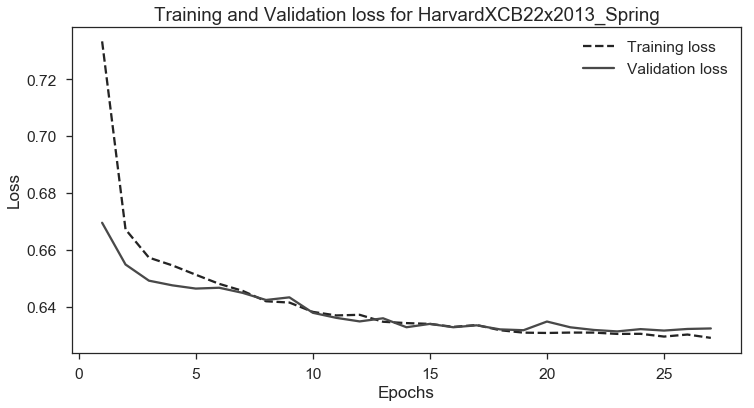

In [34]:
plot_loss(model_output.history, COURSE_LIST[course_idx])

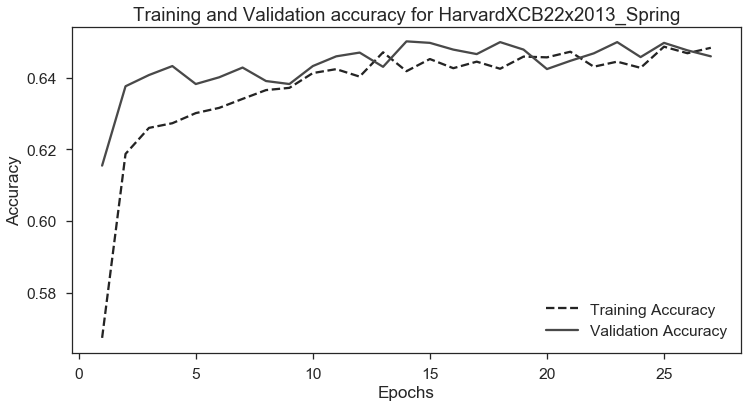

In [35]:
plot_accuracy(model_output.history, COURSE_LIST[course_idx])

##### Load the best model and compute metrics

In [ ]:
best_model = load_model('best-keras-runs/HarvardXCB22x2013_Spring-24-0.65.hdf5')

In [ ]:
best_model.evaluate(features_train, labels_train, batch_size=128)

In [ ]:
course_metrics['course_name'].append(COURSE_LIST[course_idx])
course_metrics['val_binary_accuracy'].append(best_model.evaluate(features_train, labels_train, batch_size=128)[-1])

course_metrics['test_accuracy'].append(accuracy_score(best_model.predict_classes(features_test), labels_test))
course_metrics['test_f1_score'].append(f1_score(best_model.predict_classes(features_test), labels_test))

### 2. CS50x - Introduction to Computer Science I

In [ ]:
course_idx = 1
print(COURSE_LIST[course_idx])

In [ ]:
course_loc = DATA_DIR + COURSE_LIST[course_idx]
print(course_loc)

In [ ]:
features_train = pd.read_feather(course_loc + '_features_train.feather').drop('index', axis=1)
features_test = pd.read_feather(course_loc + '_features_test.feather').drop('index', axis=1)

labels_train = pd.read_feather(course_loc + '_labels_train.feather').drop('index', axis=1)
labels_test = pd.read_feather(course_loc + '_labels_test.feather').drop('index', axis=1)

In [ ]:
features_train = np.array(features_train)
features_test = np.array(features_test)

labels_train = np.array(labels_train).ravel()
labels_test = np.array(labels_test).ravel()

In [ ]:
features_train.shape

In [ ]:
labels_train.shape

In [ ]:
features_train, features_validation, labels_train, labels_validation = train_test_split(features_train, labels_train, 
                                                                                        test_size=0.2, 
                                                                                        random_state=20130810)

In [ ]:
features_train.shape, features_validation.shape

In [ ]:
labels_train.shape, labels_validation.shape

In [ ]:
K.clear_session()

In [ ]:
model = build(nb_initial_layer=32, dense_layer_lst=[32, 32, 32], dpt_rate=0.1, learning_rate=1e-4)
model.summary()

In [ ]:
# We wish to save multiple best models.
# This strategy would be useful if we are going to use an ensemble

out_file_path='best-keras-runs/' + \
               COURSE_LIST[course_idx] + \
              '-{epoch:02d}-{val_binary_accuracy:.2f}.hdf5'

In [ ]:
#out_file_path='best-keras-runs/' + \
#               COURSE_LIST[course_idx] + \
#              '-best-model.hdf5'

In [ ]:
model_output = model.fit(features_train, labels_train,
                         batch_size=128,
                         epochs=100,
                         validation_data=[features_validation, labels_validation],
                         callbacks=[EarlyStopping(patience=4), 
                                    ReduceLROnPlateau(patience=4, min_lr=1e-6),
                                    ModelCheckpoint(out_file_path, 
                                                    monitor='val_binary_accuracy',
                                                    mode='max',
                                                    verbose=1, 
                                                    save_best_only=True, 
                                                    save_weights_only=False)])

In [ ]:
plot_loss(model_output.history, COURSE_LIST[course_idx])

In [ ]:
plot_accuracy(model_output.history, COURSE_LIST[course_idx])

##### Load the best model and compute metrics

In [ ]:
best_model = load_model('best-keras-runs/HarvardXCS50x2012-33-0.68.hdf5')

In [ ]:
best_model.evaluate(features_train, labels_train, batch_size=128)

In [ ]:
course_metrics['course_name'].append(COURSE_LIST[course_idx])
course_metrics['val_binary_accuracy'].append(best_model.evaluate(features_train, labels_train, batch_size=128)[-1])

course_metrics['test_accuracy'].append(accuracy_score(best_model.predict_classes(features_test), labels_test))
course_metrics['test_f1_score'].append(f1_score(best_model.predict_classes(features_test), labels_test))

### 3. ER22x - Justice

In [ ]:
course_idx = 2
print(COURSE_LIST[course_idx])

In [ ]:
course_loc = DATA_DIR + COURSE_LIST[course_idx]
print(course_loc)

In [ ]:
features_train = pd.read_feather(course_loc + '_features_train.feather').drop('index', axis=1)
features_test = pd.read_feather(course_loc + '_features_test.feather').drop('index', axis=1)

labels_train = pd.read_feather(course_loc + '_labels_train.feather').drop('index', axis=1)
labels_test = pd.read_feather(course_loc + '_labels_test.feather').drop('index', axis=1)

In [ ]:
features_train = np.array(features_train)
features_test = np.array(features_test)

labels_train = np.array(labels_train).ravel()
labels_test = np.array(labels_test).ravel()

In [ ]:
features_train.shape

In [ ]:
labels_train.shape

In [ ]:
features_train, features_validation, labels_train, labels_validation = train_test_split(features_train, labels_train, 
                                                                                        test_size=0.2, 
                                                                                        random_state=20130810)

In [ ]:
features_train.shape, features_validation.shape

In [ ]:
labels_train.shape, labels_validation.shape

In [ ]:
K.clear_session()

In [ ]:
model = build(nb_initial_layer=32, dense_layer_lst=[32, 32, 32], dpt_rate=0.1, learning_rate=1e-5)
model.summary()

In [ ]:
# We wish to save multiple best models.
# This strategy would be useful if we are going to use an ensemble

out_file_path='best-keras-runs/' + \
               COURSE_LIST[course_idx] + \
              '-{epoch:02d}-{val_binary_accuracy:.2f}.hdf5'

In [ ]:
#out_file_path='best-keras-runs/' + \
#               COURSE_LIST[course_idx] + \
#              '-best-model.hdf5'

In [ ]:
model_output = model.fit(features_train, labels_train,
                         batch_size=128,
                         epochs=100,
                         validation_data=[features_validation, labels_validation],
                         callbacks=[EarlyStopping(patience=4), 
                                    ReduceLROnPlateau(patience=4, min_lr=1e-6),
                                    ModelCheckpoint(out_file_path, 
                                                    monitor='val_binary_accuracy',
                                                    mode='max',
                                                    verbose=1, 
                                                    save_best_only=True, 
                                                    save_weights_only=False)])

In [ ]:
plot_loss(model_output.history, COURSE_LIST[course_idx])

In [ ]:
plot_accuracy(model_output.history, COURSE_LIST[course_idx])

##### Load the best model and compute metrics

In [ ]:
best_model = load_model('best-keras-runs/HarvardXER22x2013_Spring-18-0.67.hdf5')

In [ ]:
best_model.evaluate(features_train, labels_train, batch_size=128)

In [ ]:
course_metrics['course_name'].append(COURSE_LIST[course_idx])
course_metrics['val_binary_accuracy'].append(best_model.evaluate(features_train, labels_train, batch_size=128)[-1])

course_metrics['test_accuracy'].append(accuracy_score(best_model.predict_classes(features_test), labels_test))
course_metrics['test_f1_score'].append(f1_score(best_model.predict_classes(features_test), labels_test))

### 4. PH207x - Health in Numbers: Quantitative Methods in Clinical & Public Health Research

In [ ]:
course_idx = 3
print(COURSE_LIST[course_idx])

In [ ]:
course_loc = DATA_DIR + COURSE_LIST[course_idx]
print(course_loc)

In [ ]:
features_train = pd.read_feather(course_loc + '_features_train.feather').drop('index', axis=1)
features_test = pd.read_feather(course_loc + '_features_test.feather').drop('index', axis=1)

labels_train = pd.read_feather(course_loc + '_labels_train.feather').drop('index', axis=1)
labels_test = pd.read_feather(course_loc + '_labels_test.feather').drop('index', axis=1)

In [ ]:
features_train = np.array(features_train)
features_test = np.array(features_test)

labels_train = np.array(labels_train).ravel()
labels_test = np.array(labels_test).ravel()

In [ ]:
features_train.shape

In [ ]:
labels_train.shape

In [ ]:
features_train, features_validation, labels_train, labels_validation = train_test_split(features_train, labels_train, 
                                                                                        test_size=0.2, 
                                                                                        random_state=20130810)

In [ ]:
features_train.shape, features_validation.shape

In [ ]:
labels_train.shape, labels_validation.shape

In [ ]:
K.clear_session()

In [ ]:
model = build(nb_initial_layer=32, dense_layer_lst=[32, 32, 32], dpt_rate=0.01, learning_rate=1e-4)
model.summary()

In [ ]:
# We wish to save multiple best models.
# This strategy would be useful if we are going to use an ensemble

out_file_path='best-keras-runs/' + \
               COURSE_LIST[course_idx] + \
              '-8-{epoch:02d}-{val_binary_accuracy:.2f}.hdf5'

In [ ]:
#out_file_path='best-keras-runs/' + \
#               COURSE_LIST[course_idx] + \
#              '-best-model.hdf5'

In [ ]:
model_output = model.fit(features_train, labels_train,
                         batch_size=128,
                         epochs=100,
                         validation_data=[features_validation, labels_validation],
                         callbacks=[EarlyStopping(patience=4), 
                                    ReduceLROnPlateau(patience=4, min_lr=1e-6),
                                    ModelCheckpoint(out_file_path, 
                                                    monitor='val_binary_accuracy',
                                                    mode='max',
                                                    verbose=1, 
                                                    save_best_only=True, 
                                                    save_weights_only=False)])

In [ ]:
plot_loss(model_output.history, COURSE_LIST[course_idx])

In [ ]:
plot_accuracy(model_output.history, COURSE_LIST[course_idx])

##### Load the best model and compute metrics

In [ ]:
best_model = load_model('best-keras-runs/HarvardXPH207x2012_Fall-14-0.65.hdf5')

In [ ]:
best_model.evaluate(features_train, labels_train, batch_size=128)

In [ ]:
course_metrics['course_name'].append(COURSE_LIST[course_idx])
course_metrics['val_binary_accuracy'].append(best_model.evaluate(features_train, labels_train, batch_size=128)[-1])

course_metrics['test_accuracy'].append(accuracy_score(best_model.predict_classes(features_test), labels_test))
course_metrics['test_f1_score'].append(f1_score(best_model.predict_classes(features_test), labels_test))

### 5. PH278x - Human Health and Global Environmental Change

In [ ]:
course_idx = 4
print(COURSE_LIST[course_idx])

In [ ]:
course_loc = DATA_DIR + COURSE_LIST[course_idx]
print(course_loc)

In [ ]:
features_train = pd.read_feather(course_loc + '_features_train.feather').drop('index', axis=1)
features_test = pd.read_feather(course_loc + '_features_test.feather').drop('index', axis=1)

labels_train = pd.read_feather(course_loc + '_labels_train.feather').drop('index', axis=1)
labels_test = pd.read_feather(course_loc + '_labels_test.feather').drop('index', axis=1)

In [ ]:
features_train = np.array(features_train)
features_test = np.array(features_test)

labels_train = np.array(labels_train).ravel()
labels_test = np.array(labels_test).ravel()

In [ ]:
features_train.shape

In [ ]:
labels_train.shape

In [ ]:
features_train, features_validation, labels_train, labels_validation = train_test_split(features_train, labels_train, 
                                                                                        test_size=0.2, 
                                                                                        random_state=20130810)

In [ ]:
features_train.shape, features_validation.shape

In [ ]:
labels_train.shape, labels_validation.shape

In [ ]:
K.clear_session()

In [ ]:
model = build(nb_initial_layer=32, dense_layer_lst=[32, 32, 32], dpt_rate=0.2, learning_rate=1e-4)
model.summary()

In [ ]:
# We wish to save multiple best models.
# This strategy would be useful if we are going to use an ensemble

out_file_path='best-keras-runs/' + \
               COURSE_LIST[course_idx] + \
              '-6-{epoch:02d}-{val_binary_accuracy:.2f}.hdf5'

In [ ]:
#out_file_path='best-keras-runs/' + \
#               COURSE_LIST[course_idx] + \
#              '-best-model.hdf5'

In [ ]:
model_output = model.fit(features_train, labels_train,
                         batch_size=128,
                         epochs=100,
                         validation_data=[features_validation, labels_validation],
                         callbacks=[EarlyStopping(patience=4), 
                                    ReduceLROnPlateau(patience=4, min_lr=1e-6),
                                    ModelCheckpoint(out_file_path, 
                                                    monitor='val_binary_accuracy',
                                                    mode='max',
                                                    verbose=1, 
                                                    save_best_only=True, 
                                                    save_weights_only=False)])

In [ ]:
plot_loss(model_output.history, COURSE_LIST[course_idx])

In [ ]:
plot_accuracy(model_output.history, COURSE_LIST[course_idx])

##### Load the best model and compute metrics

In [ ]:
best_model = load_model('best-keras-runs/HarvardXPH278x2013_Spring-4-07-0.72.hdf5')

In [ ]:
best_model.evaluate(features_train, labels_train, batch_size=128)

In [ ]:
course_metrics['course_name'].append(COURSE_LIST[course_idx])
course_metrics['val_binary_accuracy'].append(best_model.evaluate(features_train, labels_train, batch_size=128)[-1])

course_metrics['test_accuracy'].append(accuracy_score(best_model.predict_classes(features_test), labels_test))
course_metrics['test_f1_score'].append(f1_score(best_model.predict_classes(features_test), labels_test))

### 6. MIT 14.73x - The Challenges of Global Poverty 

In [ ]:
course_idx = 5
print(COURSE_LIST[course_idx])

In [ ]:
course_loc = DATA_DIR + COURSE_LIST[course_idx]
print(course_loc)

In [ ]:
features_train = pd.read_feather(course_loc + '_features_train.feather').drop('index', axis=1)
features_test = pd.read_feather(course_loc + '_features_test.feather').drop('index', axis=1)

labels_train = pd.read_feather(course_loc + '_labels_train.feather').drop('index', axis=1)
labels_test = pd.read_feather(course_loc + '_labels_test.feather').drop('index', axis=1)

In [ ]:
features_train = np.array(features_train)
features_test = np.array(features_test)

labels_train = np.array(labels_train).ravel()
labels_test = np.array(labels_test).ravel()

In [ ]:
features_train.shape

In [ ]:
labels_train.shape

In [ ]:
features_train, features_validation, labels_train, labels_validation = train_test_split(features_train, labels_train, 
                                                                                        test_size=0.2, 
                                                                                        random_state=20130810)

In [ ]:
features_train.shape, features_validation.shape

In [ ]:
labels_train.shape, labels_validation.shape

In [ ]:
K.clear_session()

In [ ]:
model = build(nb_initial_layer=64, dense_layer_lst=[32, 32, 32], dpt_rate=0.05, learning_rate=1e-4)
model.summary()

In [ ]:
# We wish to save multiple best models.
# This strategy would be useful if we are going to use an ensemble

out_file_path='best-keras-runs/' + \
               COURSE_LIST[course_idx] + \
              '-8-{epoch:02d}-{val_binary_accuracy:.2f}.hdf5'

In [ ]:
#out_file_path='best-keras-runs/' + \
#               COURSE_LIST[course_idx] + \
#              '-best-model.hdf5'

In [ ]:
model_output = model.fit(features_train, labels_train,
                         batch_size=128,
                         epochs=100,
                         validation_data=[features_validation, labels_validation],
                         callbacks=[EarlyStopping(patience=4), 
                                    ReduceLROnPlateau(patience=4, min_lr=1e-6),
                                    ModelCheckpoint(out_file_path, 
                                                    monitor='val_binary_accuracy',
                                                    mode='max',
                                                    verbose=1, 
                                                    save_best_only=True, 
                                                    save_weights_only=False)])

In [ ]:
plot_loss(model_output.history, COURSE_LIST[course_idx])

In [ ]:
plot_accuracy(model_output.history, COURSE_LIST[course_idx])

##### Load the best model and compute metrics

In [ ]:
best_model = load_model('best-keras-runs/MITx14.73x2013_Spring-8-37-0.63.hdf5')

In [ ]:
best_model.evaluate(features_validation, labels_validation, batch_size=64)

In [ ]:
course_metrics['course_name'].append(COURSE_LIST[course_idx])
course_metrics['val_binary_accuracy'].append(best_model.evaluate(features_validation, labels_validation, batch_size=128)[-1])

course_metrics['test_accuracy'].append(accuracy_score(best_model.predict_classes(features_test), labels_test))
course_metrics['test_f1_score'].append(f1_score(best_model.predict_classes(features_test), labels_test))

### 7. MIT 2.01x - Elements of Structures

In [ ]:
course_idx = 6
print(COURSE_LIST[course_idx])

In [ ]:
course_loc = DATA_DIR + COURSE_LIST[course_idx]
print(course_loc)

In [ ]:
features_train = pd.read_feather(course_loc + '_features_train.feather').drop('index', axis=1)
features_test = pd.read_feather(course_loc + '_features_test.feather').drop('index', axis=1)

labels_train = pd.read_feather(course_loc + '_labels_train.feather').drop('index', axis=1)
labels_test = pd.read_feather(course_loc + '_labels_test.feather').drop('index', axis=1)

In [ ]:
features_train = np.array(features_train)
features_test = np.array(features_test)

labels_train = np.array(labels_train).ravel()
labels_test = np.array(labels_test).ravel()

In [ ]:
features_train.shape

In [ ]:
labels_train.shape

In [ ]:
features_train, features_validation, labels_train, labels_validation = train_test_split(features_train, labels_train, 
                                                                                        test_size=0.2, 
                                                                                        random_state=20130810)

In [ ]:
features_train.shape, features_validation.shape

In [ ]:
labels_train.shape, labels_validation.shape

In [ ]:
K.clear_session()

In [ ]:
model = build(nb_initial_layer=64, dense_layer_lst=[32, 32, 32], dpt_rate=0.05, learning_rate=1e-5)
model.summary()

In [ ]:
# We wish to save multiple best models.
# This strategy would be useful if we are going to use an ensemble

out_file_path='best-keras-runs/' + \
               COURSE_LIST[course_idx] + \
              '-11-{epoch:02d}-{val_binary_accuracy:.2f}.hdf5'

In [ ]:
#out_file_path='best-keras-runs/' + \
#               COURSE_LIST[course_idx] + \
#              '-best-model.hdf5'

In [ ]:
model_output = model.fit(features_train, labels_train,
                         batch_size=128,
                         epochs=100,
                         validation_data=[features_validation, labels_validation],
                         callbacks=[EarlyStopping(patience=4), 
                                    ReduceLROnPlateau(patience=4, min_lr=1e-6),
                                    ModelCheckpoint(out_file_path, 
                                                    monitor='val_binary_accuracy',
                                                    mode='max',
                                                    verbose=1, 
                                                    save_best_only=True, 
                                                    save_weights_only=False)])

In [ ]:
plot_loss(model_output.history, COURSE_LIST[course_idx])

In [ ]:
plot_accuracy(model_output.history, COURSE_LIST[course_idx])

##### Load the best model and compute metrics

In [ ]:
best_model = load_model('best-keras-runs/MITx2.01x2013_Spring-11-26-0.66.hdf5')

In [ ]:
best_model.evaluate(features_train, labels_train, batch_size=128)

In [ ]:
course_metrics['course_name'].append(COURSE_LIST[course_idx])
course_metrics['val_binary_accuracy'].append(best_model.evaluate(features_validation, labels_validation, batch_size=128)[-1])

course_metrics['test_accuracy'].append(accuracy_score(best_model.predict_classes(features_test), labels_test))
course_metrics['test_f1_score'].append(f1_score(best_model.predict_classes(features_test), labels_test))

### 8. MIT 3.091x (Fall) - Introduction to Solid State Chemistry

In [ ]:
course_idx = 7
print(COURSE_LIST[course_idx])

In [ ]:
course_loc = DATA_DIR + COURSE_LIST[course_idx]
print(course_loc)

In [ ]:
features_train = pd.read_feather(course_loc + '_features_train.feather').drop('index', axis=1)
features_test = pd.read_feather(course_loc + '_features_test.feather').drop('index', axis=1)

labels_train = pd.read_feather(course_loc + '_labels_train.feather').drop('index', axis=1)
labels_test = pd.read_feather(course_loc + '_labels_test.feather').drop('index', axis=1)

In [ ]:
features_train = np.array(features_train)
features_test = np.array(features_test)

labels_train = np.array(labels_train).ravel()
labels_test = np.array(labels_test).ravel()

In [ ]:
features_train.shape

In [ ]:
labels_train.shape

In [ ]:
features_train, features_validation, labels_train, labels_validation = train_test_split(features_train, labels_train, 
                                                                                        test_size=0.2, 
                                                                                        random_state=20130810)

In [ ]:
features_train.shape, features_validation.shape

In [ ]:
labels_train.shape, labels_validation.shape

In [ ]:
K.clear_session()

In [ ]:
model = build(nb_initial_layer=64, dense_layer_lst=[32, 32, 32], dpt_rate=0.01, learning_rate=1e-5)
model.summary()

In [ ]:
# We wish to save multiple best models.
# This strategy would be useful if we are going to use an ensemble

out_file_path='best-keras-runs/' + \
               COURSE_LIST[course_idx] + \
              '-6-{epoch:02d}-{val_binary_accuracy:.2f}.hdf5'

In [ ]:
#out_file_path='best-keras-runs/' + \
#               COURSE_LIST[course_idx] + \
#              '-best-model.hdf5'

In [ ]:
model_output = model.fit(features_train, labels_train,
                         batch_size=128,
                         epochs=100,
                         validation_data=[features_validation, labels_validation],
                         callbacks=[EarlyStopping(patience=4), 
                                    ReduceLROnPlateau(patience=4, min_lr=1e-6),
                                    ModelCheckpoint(out_file_path, 
                                                    monitor='val_binary_accuracy',
                                                    mode='max',
                                                    verbose=1, 
                                                    save_best_only=True, 
                                                    save_weights_only=False)])

In [ ]:
plot_loss(model_output.history, COURSE_LIST[course_idx])

In [ ]:
plot_accuracy(model_output.history, COURSE_LIST[course_idx])

##### Load the best model and compute metrics

In [ ]:
best_model = load_model('best-keras-runs/MITx2.01x2013_Spring-11-26-0.66.hdf5')

In [ ]:
best_model.evaluate(features_train, labels_train, batch_size=128)

In [ ]:
course_metrics['course_name'].append(COURSE_LIST[course_idx])
course_metrics['val_binary_accuracy'].append(best_model.evaluate(features_validation, labels_validation, batch_size=128)[-1])

course_metrics['test_accuracy'].append(accuracy_score(best_model.predict_classes(features_test), labels_test))
course_metrics['test_f1_score'].append(f1_score(best_model.predict_classes(features_test), labels_test))

### 9. MIT 3.091x (Spring) - Introduction to Solid State Chemistry 

In [ ]:
course_idx = 8
print(COURSE_LIST[course_idx])

In [ ]:
course_loc = DATA_DIR + COURSE_LIST[course_idx]
print(course_loc)

In [ ]:
features_train = pd.read_feather(course_loc + '_features_train.feather').drop('index', axis=1)
features_test = pd.read_feather(course_loc + '_features_test.feather').drop('index', axis=1)

labels_train = pd.read_feather(course_loc + '_labels_train.feather').drop('index', axis=1)
labels_test = pd.read_feather(course_loc + '_labels_test.feather').drop('index', axis=1)

In [ ]:
features_train = np.array(features_train)
features_test = np.array(features_test)

labels_train = np.array(labels_train).ravel()
labels_test = np.array(labels_test).ravel()

In [ ]:
features_train.shape

In [ ]:
labels_train.shape

In [ ]:
K.clear_session()

In [ ]:
model = build(nb_initial_layer=64, dense_layer_lst=[32, 32, 32], dpt_rate=0.05, learning_rate=1e-2)
model.summary()

In [ ]:
model_output = model.fit(features_train, labels_train,
                         batch_size=128,
                         epochs=50,
                         validation_split=0.2,
                         callbacks=[EarlyStopping(patience=4), 
                                    ReduceLROnPlateau(patience=4, min_lr=1e-6)])

In [ ]:
course_metrics['course_name'].append(COURSE_LIST[course_idx])
course_metrics['val_binary_accuracy'].append(model_output.history['val_binary_accuracy'][-1])
course_metrics['test_accuracy'].append(accuracy_score(model.predict_classes(features_test), labels_test))
course_metrics['test_f1_score'].append(f1_score(model.predict_classes(features_test), labels_test))

### 10. MIT 6.002x (Fall) - Circuits and Electronics

In [ ]:
course_idx = 9
print(COURSE_LIST[course_idx])

In [ ]:
course_loc = DATA_DIR + COURSE_LIST[course_idx]
print(course_loc)

In [ ]:
features_train = pd.read_feather(course_loc + '_features_train.feather').drop('index', axis=1)
features_test = pd.read_feather(course_loc + '_features_test.feather').drop('index', axis=1)

labels_train = pd.read_feather(course_loc + '_labels_train.feather').drop('index', axis=1)
labels_test = pd.read_feather(course_loc + '_labels_test.feather').drop('index', axis=1)

In [ ]:
features_train = np.array(features_train)
features_test = np.array(features_test)

labels_train = np.array(labels_train).ravel()
labels_test = np.array(labels_test).ravel()

In [ ]:
features_train.shape

In [ ]:
labels_train.shape

In [ ]:
K.clear_session()

In [ ]:
model = build(nb_initial_layer=64, dense_layer_lst=[32, 32, 32], dpt_rate=0.05, learning_rate=1e-2)
model.summary()

In [ ]:
model_output = model.fit(features_train, labels_train,
                         batch_size=128,
                         epochs=50,
                         validation_split=0.2,
                         callbacks=[EarlyStopping(patience=4), 
                                    ReduceLROnPlateau(patience=4, min_lr=1e-6)])

In [ ]:
course_metrics['course_name'].append(COURSE_LIST[course_idx])
course_metrics['val_binary_accuracy'].append(model_output.history['val_binary_accuracy'][-1])
course_metrics['test_accuracy'].append(accuracy_score(model.predict_classes(features_test), labels_test))
course_metrics['test_f1_score'].append(f1_score(model.predict_classes(features_test), labels_test))

### 11. MIT 6.002x (Spring) - Circuits and Electronics

In [ ]:
course_idx = 10
print(COURSE_LIST[course_idx])

In [ ]:
course_loc = DATA_DIR + COURSE_LIST[course_idx]
print(course_loc)

In [ ]:
features_train = pd.read_feather(course_loc + '_features_train.feather').drop('index', axis=1)
features_test = pd.read_feather(course_loc + '_features_test.feather').drop('index', axis=1)

labels_train = pd.read_feather(course_loc + '_labels_train.feather').drop('index', axis=1)
labels_test = pd.read_feather(course_loc + '_labels_test.feather').drop('index', axis=1)

In [ ]:
features_train = np.array(features_train)
features_test = np.array(features_test)

labels_train = np.array(labels_train).ravel()
labels_test = np.array(labels_test).ravel()

In [ ]:
features_train.shape

In [ ]:
labels_train.shape

In [ ]:
K.clear_session()

In [ ]:
model = build(nb_initial_layer=64, dense_layer_lst=[32, 32, 32], dpt_rate=0.05, learning_rate=1e-2)
model.summary()

In [ ]:
model_output = model.fit(features_train, labels_train,
                         batch_size=128,
                         epochs=50,
                         validation_split=0.2,
                         callbacks=[EarlyStopping(patience=4), 
                                    ReduceLROnPlateau(patience=4, min_lr=1e-6)])

In [ ]:
course_metrics['course_name'].append(COURSE_LIST[course_idx])
course_metrics['val_binary_accuracy'].append(model_output.history['val_binary_accuracy'][-1])
course_metrics['test_accuracy'].append(accuracy_score(model.predict_classes(features_test), labels_test))
course_metrics['test_f1_score'].append(f1_score(model.predict_classes(features_test), labels_test))

### 12. MIT 6.00x (Fall) - Introduction to Computer Science

In [ ]:
course_idx = 11
print(COURSE_LIST[course_idx])

In [ ]:
course_loc = DATA_DIR + COURSE_LIST[course_idx]
print(course_loc)

In [ ]:
features_train = pd.read_feather(course_loc + '_features_train.feather').drop('index', axis=1)
features_test = pd.read_feather(course_loc + '_features_test.feather').drop('index', axis=1)

labels_train = pd.read_feather(course_loc + '_labels_train.feather').drop('index', axis=1)
labels_test = pd.read_feather(course_loc + '_labels_test.feather').drop('index', axis=1)

In [ ]:
features_train = np.array(features_train)
features_test = np.array(features_test)

labels_train = np.array(labels_train).ravel()
labels_test = np.array(labels_test).ravel()

In [ ]:
features_train.shape

In [ ]:
labels_train.shape

In [ ]:
K.clear_session()

In [ ]:
model = build(nb_initial_layer=64, dense_layer_lst=[32, 32, 32], dpt_rate=0.05, learning_rate=1e-2)
model.summary()

In [ ]:
model_output = model.fit(features_train, labels_train,
                         batch_size=128,
                         epochs=50,
                         validation_split=0.2,
                         callbacks=[EarlyStopping(patience=4), 
                                    ReduceLROnPlateau(patience=4, min_lr=1e-6)])

In [ ]:
course_metrics['course_name'].append(COURSE_LIST[course_idx])
course_metrics['val_binary_accuracy'].append(model_output.history['val_binary_accuracy'][-1])
course_metrics['test_accuracy'].append(accuracy_score(model.predict_classes(features_test), labels_test))
course_metrics['test_f1_score'].append(f1_score(model.predict_classes(features_test), labels_test))

### 13. MIT 6.00x (Spring) - Introduction to Computer Science

In [ ]:
course_idx = 12
print(COURSE_LIST[course_idx])

In [ ]:
course_loc = DATA_DIR + COURSE_LIST[course_idx]
print(course_loc)

In [ ]:
features_train = pd.read_feather(course_loc + '_features_train.feather').drop('index', axis=1)
features_test = pd.read_feather(course_loc + '_features_test.feather').drop('index', axis=1)

labels_train = pd.read_feather(course_loc + '_labels_train.feather').drop('index', axis=1)
labels_test = pd.read_feather(course_loc + '_labels_test.feather').drop('index', axis=1)

In [ ]:
features_train = np.array(features_train)
features_test = np.array(features_test)

labels_train = np.array(labels_train).ravel()
labels_test = np.array(labels_test).ravel()

In [ ]:
features_train.shape

In [ ]:
labels_train.shape

In [ ]:
K.clear_session()

In [ ]:
model = build(nb_initial_layer=64, dense_layer_lst=[32, 32, 32], dpt_rate=0.05, learning_rate=1e-2)
model.summary()

In [ ]:
model_output = model.fit(features_train, labels_train,
                         batch_size=128,
                         epochs=50,
                         validation_split=0.2,
                         callbacks=[EarlyStopping(patience=4), 
                                    ReduceLROnPlateau(patience=4, min_lr=1e-6)])

In [ ]:
course_metrics['course_name'].append(COURSE_LIST[course_idx])
course_metrics['val_binary_accuracy'].append(model_output.history['val_binary_accuracy'][-1])
course_metrics['test_accuracy'].append(accuracy_score(model.predict_classes(features_test), labels_test))
course_metrics['test_f1_score'].append(f1_score(model.predict_classes(features_test), labels_test))

### 14. MIT 7.00x - Introduction to Biology - secret of life

In [ ]:
course_idx = 13
print(COURSE_LIST[course_idx])

In [ ]:
course_loc = DATA_DIR + COURSE_LIST[course_idx]
print(course_loc)

In [ ]:
features_train = pd.read_feather(course_loc + '_features_train.feather').drop('index', axis=1)
features_test = pd.read_feather(course_loc + '_features_test.feather').drop('index', axis=1)

labels_train = pd.read_feather(course_loc + '_labels_train.feather').drop('index', axis=1)
labels_test = pd.read_feather(course_loc + '_labels_test.feather').drop('index', axis=1)

In [ ]:
features_train = np.array(features_train)
features_test = np.array(features_test)

labels_train = np.array(labels_train).ravel()
labels_test = np.array(labels_test).ravel()

In [ ]:
features_train.shape

In [ ]:
labels_train.shape

In [ ]:
K.clear_session()

In [ ]:
model = build(nb_initial_layer=64, dense_layer_lst=[32, 32, 32], dpt_rate=0.05, learning_rate=1e-2)
model.summary()

In [ ]:
model_output = model.fit(features_train, labels_train,
                         batch_size=128,
                         epochs=50,
                         validation_split=0.2,
                         callbacks=[EarlyStopping(patience=4), 
                                    ReduceLROnPlateau(patience=4, min_lr=1e-6)])

In [ ]:
course_metrics['course_name'].append(COURSE_LIST[course_idx])
course_metrics['val_binary_accuracy'].append(model_output.history['val_binary_accuracy'][-1])
course_metrics['test_accuracy'].append(accuracy_score(model.predict_classes(features_test), labels_test))
course_metrics['test_f1_score'].append(f1_score(model.predict_classes(features_test), labels_test))

### 15. MIT 8.02x - Electricity and Magnetism

In [ ]:
course_idx = 14
print(COURSE_LIST[course_idx])

In [ ]:
course_loc = DATA_DIR + COURSE_LIST[course_idx]
print(course_loc)

In [ ]:
features_train = pd.read_feather(course_loc + '_features_train.feather').drop('index', axis=1)
features_test = pd.read_feather(course_loc + '_features_test.feather').drop('index', axis=1)

labels_train = pd.read_feather(course_loc + '_labels_train.feather').drop('index', axis=1)
labels_test = pd.read_feather(course_loc + '_labels_test.feather').drop('index', axis=1)

In [ ]:
features_train = np.array(features_train)
features_test = np.array(features_test)

labels_train = np.array(labels_train).ravel()
labels_test = np.array(labels_test).ravel()

In [ ]:
features_train.shape

In [ ]:
labels_train.shape

In [ ]:
K.clear_session()

In [ ]:
model = build(nb_initial_layer=64, dense_layer_lst=[32, 32, 32], dpt_rate=0.05, learning_rate=1e-2)
model.summary()

In [ ]:
model_output = model.fit(features_train, labels_train,
                         batch_size=128,
                         epochs=50,
                         validation_split=0.2,
                         callbacks=[EarlyStopping(patience=4), 
                                    ReduceLROnPlateau(patience=4, min_lr=1e-6)])

In [ ]:
course_metrics['course_name'].append(COURSE_LIST[course_idx])
course_metrics['val_binary_accuracy'].append(model_output.history['val_binary_accuracy'][-1])
course_metrics['test_accuracy'].append(accuracy_score(model.predict_classes(features_test), labels_test))
course_metrics['test_f1_score'].append(f1_score(model.predict_classes(features_test), labels_test))

### 16. MIT 8.MReV - Mechanics Review

In [ ]:
course_idx = 15
print(COURSE_LIST[course_idx])

In [ ]:
course_loc = DATA_DIR + COURSE_LIST[course_idx]
print(course_loc)

In [ ]:
features_train = pd.read_feather(course_loc + '_features_train.feather').drop('index', axis=1)
features_test = pd.read_feather(course_loc + '_features_test.feather').drop('index', axis=1)

labels_train = pd.read_feather(course_loc + '_labels_train.feather').drop('index', axis=1)
labels_test = pd.read_feather(course_loc + '_labels_test.feather').drop('index', axis=1)

In [ ]:
features_train = np.array(features_train)
features_test = np.array(features_test)

labels_train = np.array(labels_train).ravel()
labels_test = np.array(labels_test).ravel()

In [ ]:
features_train.shape

In [ ]:
labels_train.shape

In [ ]:
K.clear_session()

In [ ]:
model = build(nb_initial_layer=64, dense_layer_lst=[32, 32, 32], dpt_rate=0.05, learning_rate=1e-2)
model.summary()

In [ ]:
model_output = model.fit(features_train, labels_train,
                         batch_size=128,
                         epochs=50,
                         validation_split=0.2,
                         callbacks=[EarlyStopping(patience=4), 
                                    ReduceLROnPlateau(patience=4, min_lr=1e-6)])

In [ ]:
course_metrics['course_name'].append(COURSE_LIST[course_idx])
course_metrics['val_binary_accuracy'].append(model_output.history['val_binary_accuracy'][-1])
course_metrics['test_accuracy'].append(accuracy_score(model.predict_classes(features_test), labels_test))
course_metrics['test_f1_score'].append(f1_score(model.predict_classes(features_test), labels_test))